In [2]:
import torch
from torchvision import models, transforms
from PIL import Image

# Load MobileNetV2 pre-trained model
model = models.mobilenet_v2(pretrained=True)
model = torch.nn.Sequential(*(list(model.children())[:-1]))  # Remove classification head
model.eval()

Sequential(
  (0): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05, m

In [3]:
from dataclasses import dataclass
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from diffusers import DDPMScheduler, UNet2DModel
from matplotlib import pyplot as plt
import torchvision
from torchvision import transforms

@dataclass
class Config:
    image_size = 128  # the generated image resolution
    train_batch_size = 16
    eval_batch_size = 16  # how many images to sample during evaluation
    num_epochs = 100
    gradient_accumulation_steps = 1
    learning_rate = 1e-4
    lr_warmup_steps = 500
    save_image_epochs = 10
    save_model_epochs = 30
    mixed_precision = "fp16"  # `no` for float32, `fp16` for automatic mixed precision
    output_dir = "samples"  # the model name locally and on the HF Hub

    push_to_hub = False  # whether to upload the saved model to the HF Hub
    hub_model_id = "<your-username>/<my-awesome-model>"  # the name of the repository to create on the HF Hub
    hub_private_repo = False
    overwrite_output_dir = True  # overwrite the old model when re-running the notebook
    seed = 0


config = Config()
config.dataset_name = "data"

In [132]:
from torchvision import transforms

preprocess = transforms.Compose(
    [
        transforms.Resize((config.image_size, config.image_size)),
        # transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        # transforms.Normalize([0.5], [0.5]),
    ]
)
dataset = torchvision.datasets.ImageFolder(config.dataset_name, preprocess)
dataset

Dataset ImageFolder
    Number of datapoints: 2287
    Root location: data
    StandardTransform
Transform: Compose(
               Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )

In [203]:
from diffusers import DDPMPipeline

def generate(pipeline, num_images=1, config=config):
    # Sample some images from random noise (this is the backward diffusion process).
    # The default pipeline output type is `List[PIL.Image]`
    images = pipeline(
        batch_size=num_images,
        # random seed for reproducibility
        generator=torch.Generator(device='cpu').manual_seed(5),  # seed 42 works well for this example
    ).images
    return images

# Load the trained pipeline
pipeline = DDPMPipeline.from_pretrained(config.output_dir)

# Ensure pipeline is set to evaluation mode
pipeline.unet.eval()

# Define the device for computation
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
pipeline.to(device)

# Generate images (now passing pipeline, not config)
images = generate(pipeline, num_images=1)  # Example: generating 1 image

Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

cuda


  0%|          | 0/1000 [00:00<?, ?it/s]

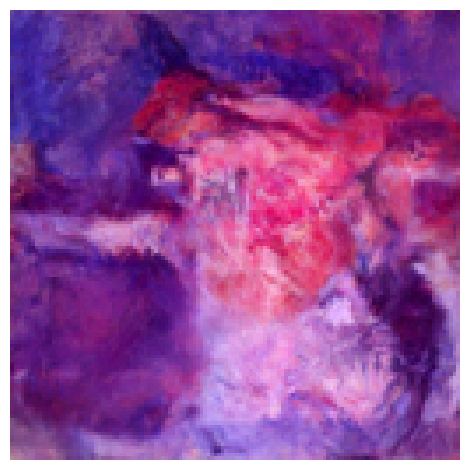

In [204]:
# Calculate exact grid dimensions
from diffusers.utils import make_image_grid
# only 8 first
num_images = len(images)
cols = min(num_images, 4)  # Max 4 columns
rows = (num_images + cols - 1) // cols  # Compute rows to fit all images
# Make a grid out of the images 4 columns and the rest rows

image_grid = make_image_grid(images, rows=rows, cols=cols)
plt.imshow(image_grid)
plt.axis("off")
plt.tight_layout()
plt.show()

In [205]:
# transform <PIL.Image.Image image mode=RGB size=128x128> to tensor
img_tensor = transforms.ToTensor()(images[0])
# inverse the preprocess
img_tensor.shape

torch.Size([3, 128, 128])

In [206]:
# Generate embeddings
def get_embedding(img_tensor):
    with torch.no_grad():
        embedding = model(img_tensor).squeeze()  # Extract embedding
    # embedding is shape: (1280 ,4 , 4) ->adaptive_avg_pool2d
    embedding = torch.nn.functional.adaptive_avg_pool2d(embedding, (1, 1)).squeeze().numpy()
    # embedding is shape: (1280 ,4 , 4) -> global max pooling
    # embedding = torch.nn.functional.adaptive_max_pool2d(embedding, (1, 1)).squeeze().numpy()
    # embedding is shape: (1280 ,4 , 4) -> flatten
    # embedding = torch.flatten(embedding).numpy()
    return embedding

In [207]:
dataset[0][0].shape

torch.Size([3, 128, 128])

In [216]:
from scipy.spatial.distance import cosine
from tqdm.notebook import tqdm

idx_max = None
cosine_max = 0
similarities = []
for i in tqdm(range(len(dataset))):
    embedding1 = get_embedding(dataset[i][0].unsqueeze(0))
    embedding2 = get_embedding(img_tensor.unsqueeze(0))
    similarity = cosine(embedding1, embedding2)
    similarities.append(similarity)
    if similarity > cosine_max:
        cosine_max = similarity
        idx_max = i

  0%|          | 0/2287 [00:00<?, ?it/s]

In [217]:
idx_max, cosine_max

(1202, 0.7450075443640298)

In [218]:
# get the 5 most similar images
similarities = torch.tensor(similarities)
_, indices = torch.topk(similarities, 5)
indices

tensor([1202,  481, 1571,   20,  401])

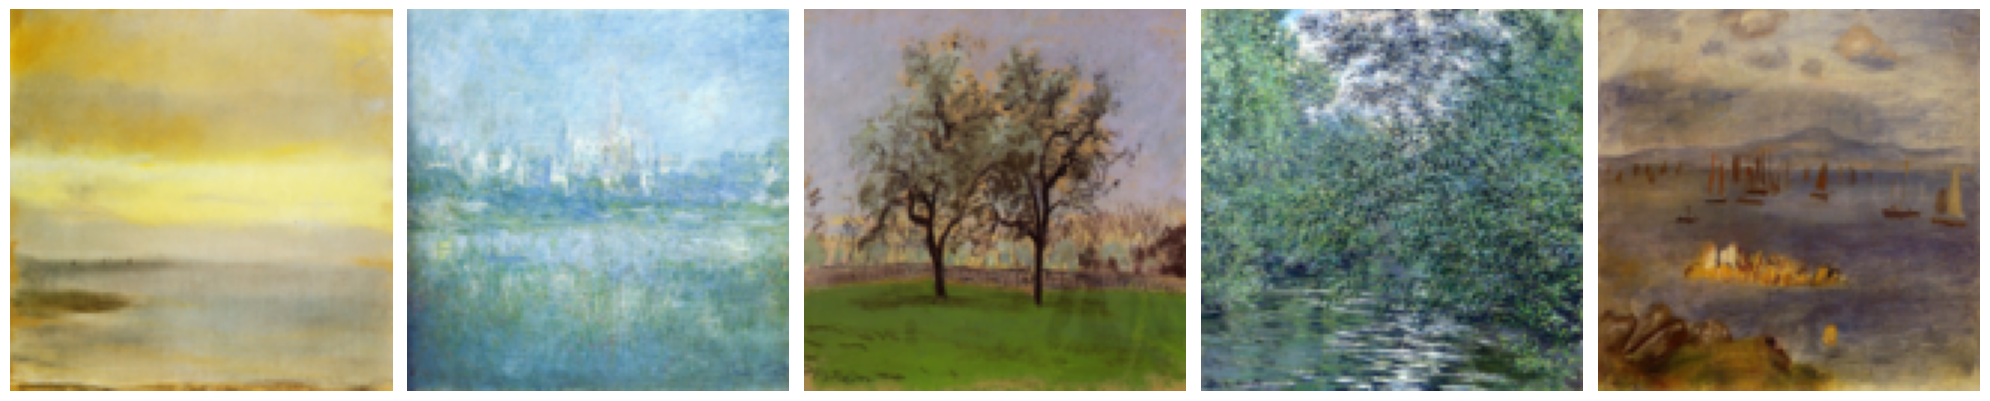

In [219]:
# plot the 5 most similar images
fig, axs = plt.subplots(1, 5, figsize=(20, 20))
for i, ax in enumerate(axs):
    image = dataset[indices[i]][0]
    show_image = transforms.ToPILImage()(image)
    ax.imshow(show_image)
    ax.axis("off")
plt.tight_layout()
plt.show()

Text(0, 0.5, 'Frequency')

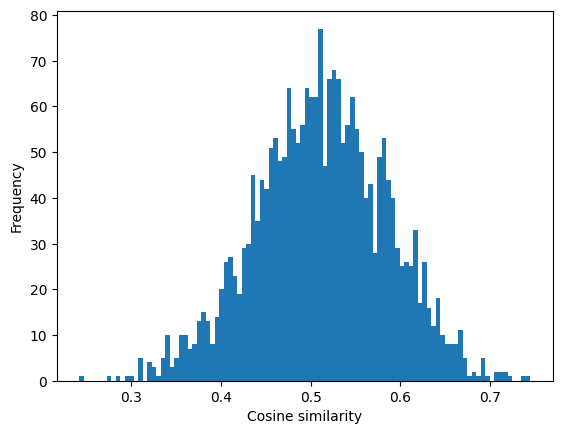

In [220]:
# histogram of similarities
plt.hist(similarities, bins=100)
plt.xlabel("Cosine similarity")
plt.ylabel("Frequency")


In [226]:
idx_max = None
mse = 10**9
similarities = []
for i in tqdm(range(len(dataset))):
    img1 = dataset[i][0].unsqueeze(0)
    img2 = img_tensor.unsqueeze(0)
    # similarity is MSE between two embeddings
    similarity = torch.nn.functional.mse_loss(model(img1).squeeze(), model(img2).squeeze()).item()
    similarities.append(similarity)
    if similarity < mse:
        cosine_max = similarity
        idx_max = i

  0%|          | 0/2287 [00:00<?, ?it/s]

In [227]:
# get the 5 most similar images
similarities = torch.tensor(similarities)
_, indices = torch.topk(similarities, 5)
indices

tensor([ 916,  748,  243, 1628, 2092])

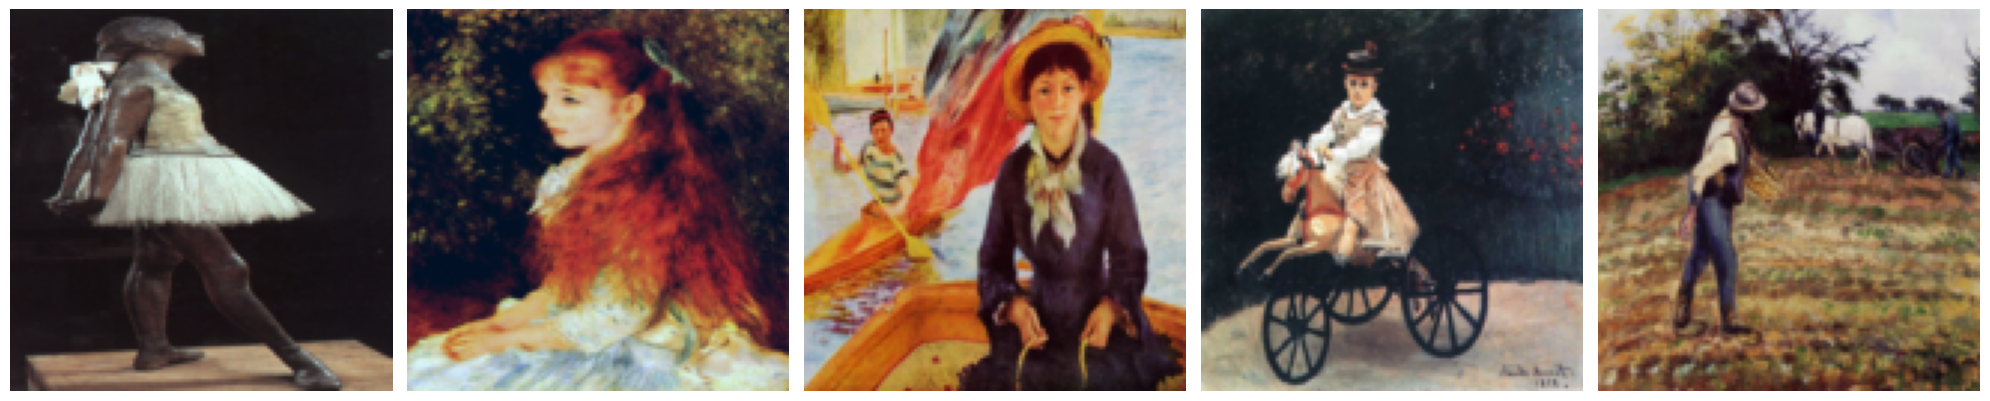

In [228]:
# plot the 5 most similar images
fig, axs = plt.subplots(1, 5, figsize=(20, 20))
for i, ax in enumerate(axs):
    image = dataset[indices[i]][0]
    show_image = transforms.ToPILImage()(image)
    ax.imshow(show_image)
    ax.axis("off")
plt.tight_layout()
plt.show()

Text(0, 0.5, 'Frequency')

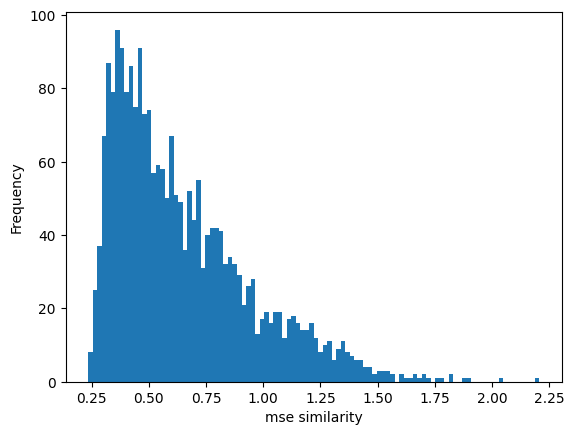

In [229]:
# histogram of similarities
plt.hist(similarities, bins=100)
plt.xlabel("mse similarity")
plt.ylabel("Frequency")
